In [1]:
import torch
from torch import nn
from torchmetrics import Accuracy
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import torchvision
from torchvision import transforms , datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from timeit import default_timer as timer

In [2]:
new_path = r"D:\data science\fashion mnist dataset"  # Replace with your desired path
os.chdir(new_path)
print("Directory changed to:", os.getcwd())

Directory changed to: D:\data science\fashion mnist dataset


In [3]:
train_data = datasets.FashionMNIST(
    root = r"D:\data science\fashion mnist dataset" , 
    train = True , #if true get training data else: get test data
    download = True,
    transform= torchvision.transforms.ToTensor(), #how do we want to transform the data
    target_transform= None # how do we want to transform the labels
)

test_data = train_data = datasets.FashionMNIST(
    root = r"D:\data science\fashion mnist dataset" , 
    train = False , #if true get training data else: get test data
    download = True,
    transform= torchvision.transforms.ToTensor(), #how do we want to transform the data
)

In [4]:
len(train_data)

10000

In [5]:
len(test_data)

10000

In [6]:
# See first training sample
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [7]:
image.shape 

torch.Size([1, 28, 28])

In [8]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

c * H * W
1. NOW PERMUTE THEM WITH .permute(1,2,0)
2. image.squeeze()

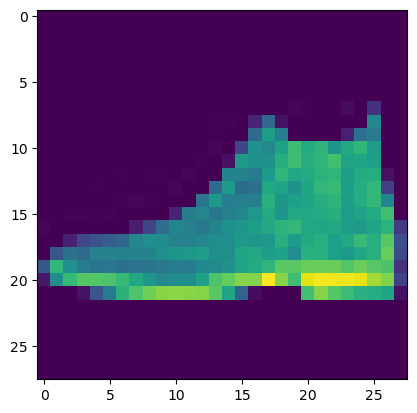

In [9]:
plt.imshow(image.permute(1, 2, 0).numpy());

Text(0.5, 1.0, 'Ankle boot')

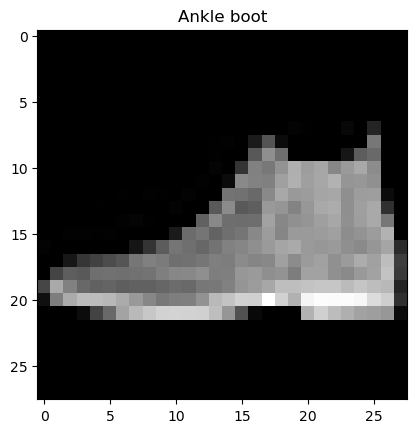

In [10]:
plt.imshow(image.permute(1, 2, 0).numpy() ,cmap = "gray");
plt.title(class_names[label])

In [11]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [12]:
train_data.targets.unique() #labels

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

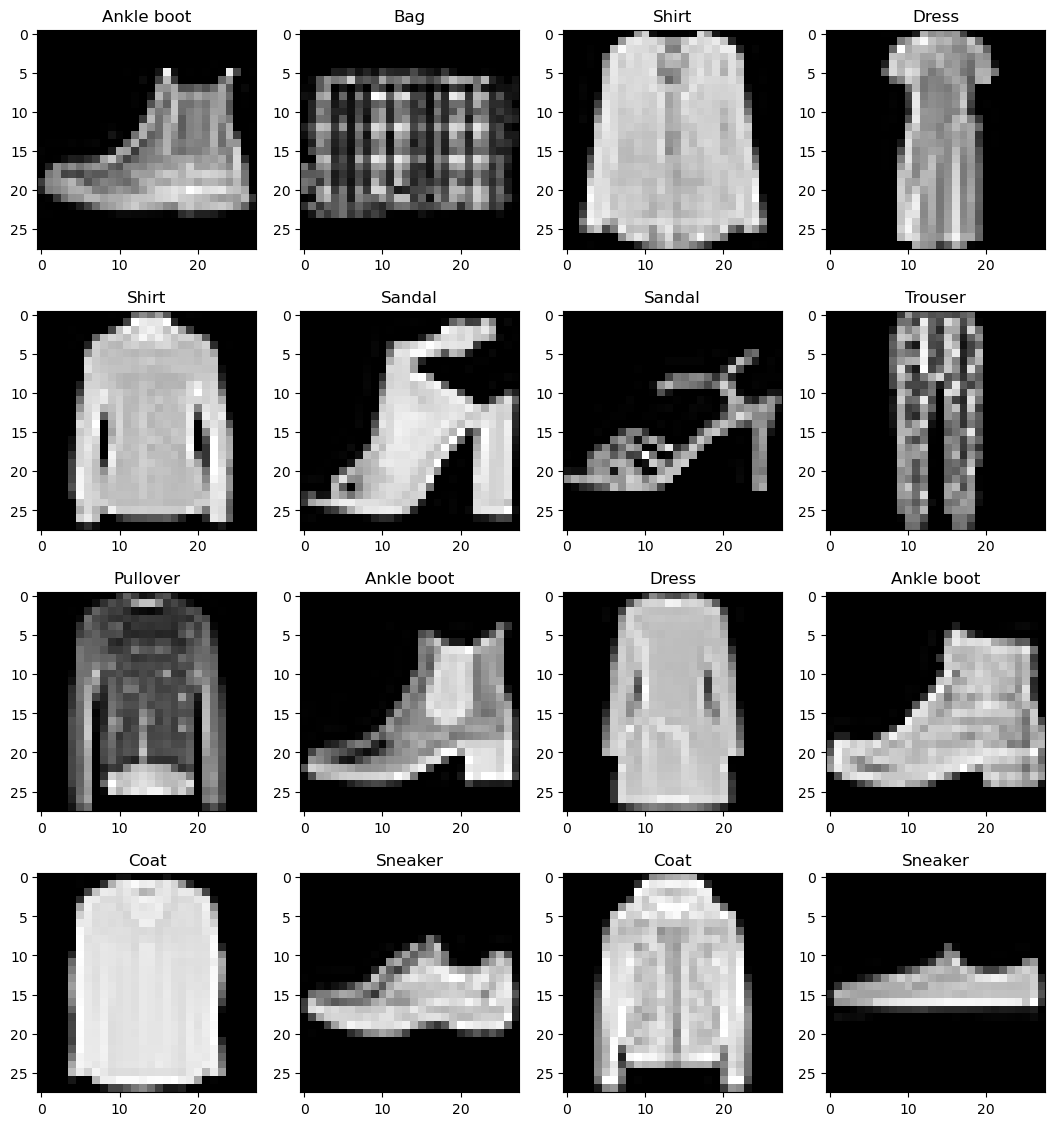

In [13]:
torch.manual_seed(42)
rows , cols = 4 , 4
fig = plt.figure(figsize=(13,14))
for i in range(1 , rows*cols +1):
    random_idx = torch.randint(0 , len(train_data) , size = [1]).item()
    img , label = train_data[random_idx]
    
    fig.add_subplot(rows , cols , i)
    plt.imshow(img.squeeze() , cmap = "gray")
    plt.title(class_names[label])


dataloader turns dataset into python iterable 

batchsize: good for memory (maybe 32) , gives NN more chances to update per epoch 

In [14]:
BATCH_SIZE = 32 #batches 
train_dataloader = DataLoader(dataset = train_data , batch_size = BATCH_SIZE , shuffle = True) # int(len(train_dataloader/batch_size))
test_dataloader  = DataLoader(dataset = test_data  , batch_size= BATCH_SIZE , shuffle = False) 

In [15]:
train_feature_batch , train_label_batch=next(iter(train_dataloader))
train_feature_batch.shape , train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Text(0.5, 1.0, 'Pullover')

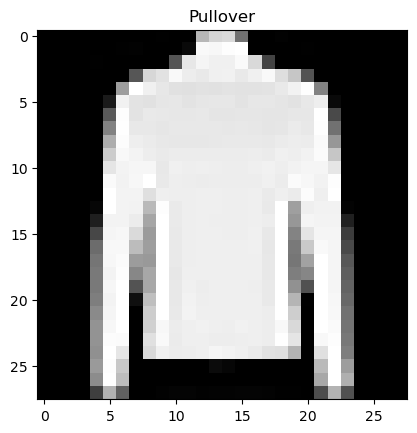

In [16]:
#torch.manual_seed(42)
random_idx = torch.randint(0 , len(train_feature_batch) , size = [1]).item()
img,label = train_feature_batch[random_idx] , train_label_batch[random_idx]
plt.imshow(img.squeeze() , cmap = "gray")
plt.title(class_names[label])

base model:

flatten_layer

In [17]:
x = train_feature_batch[0]
print("x before flatten" ,x.shape)
flatten_model = nn.Flatten()
print("x after flatten" ,flatten_model(x).shape) #color channels * (height*width)

x before flatten torch.Size([1, 28, 28])
x after flatten torch.Size([1, 784])


In [43]:
class ImageModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
      
            nn.Linear(in_features=hidden_units, out_features=output_shape),
       
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [44]:
class ImageModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [51]:
class ImageModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Tanh(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.Tanh()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [52]:
torch.manual_seed(42)
model_0 = ImageModelV2(784 , 10 , len(class_names))
model_0

ImageModelV2(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Tanh()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Tanh()
  )
)

In [53]:
dummy_x = torch.rand([1 , 1 , 28 , 28])
model_0(dummy_x).shape

torch.Size([1, 10])

In [54]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters() , lr = 0.1)

In [55]:
def print_train_time(start , end):
    total_time = end-start
    return total_time

In [56]:
acc = Accuracy(task='multiclass',num_classes=10)

In [57]:
torch.manual_seed(42)
start_time = timer()
#--------------------
epochs = 20
for epoch in tqdm(range(epochs)):
    print(f"Epoch : {epoch}\n-----")    
    train_loss = 0
    for batch , (image , label) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(image)
        loss = loss_fn(y_pred , label)
        train_loss = train_loss + loss #loss on one batch of data
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch %400 == 0:
            print(f"looked at {batch*len(image)}/{len(train_dataloader.dataset)} samples")
    train_loss = train_loss / len(train_dataloader) #loss by the whole train data

    #testing
    test_loss , test_acc = 0 , 0
    model_0.eval()
    with torch.inference_mode():
        for image_test , label_test in test_dataloader:
            test_pred = model_0(image_test)
            test_loss = test_loss + loss_fn(test_pred , label_test)
            test_acc  = test_acc  + acc(test_pred.argmax(dim = 1) , label_test)
        test_loss = test_loss / len(test_dataloader) #test loss avg per batch
        test_acc  = test_acc  / len(test_dataloader)
    print(f"epoch : {epoch} | train_loss : {train_loss:.2f}  | test loss : {test_loss:.2f} , test acc : {test_acc:.2f}")
#--------------------
end_time = timer()
total_train_time_model_0 = print_train_time(start_time , end_time)
total_train_time_model_0

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 0
-----
looked at 0/10000 samples
epoch : 0 | train_loss : 1.53  | test loss : 1.31 , test acc : 0.71
Epoch : 1
-----
looked at 0/10000 samples
epoch : 1 | train_loss : 1.25  | test loss : 1.20 , test acc : 0.73
Epoch : 2
-----
looked at 0/10000 samples
epoch : 2 | train_loss : 1.18  | test loss : 1.16 , test acc : 0.75
Epoch : 3
-----
looked at 0/10000 samples
epoch : 3 | train_loss : 1.15  | test loss : 1.14 , test acc : 0.76
Epoch : 4
-----
looked at 0/10000 samples
epoch : 4 | train_loss : 1.13  | test loss : 1.11 , test acc : 0.77
Epoch : 5
-----
looked at 0/10000 samples
epoch : 5 | train_loss : 1.11  | test loss : 1.11 , test acc : 0.77
Epoch : 6
-----
looked at 0/10000 samples
epoch : 6 | train_loss : 1.10  | test loss : 1.09 , test acc : 0.78
Epoch : 7
-----
looked at 0/10000 samples
epoch : 7 | train_loss : 1.09  | test loss : 1.09 , test acc : 0.79
Epoch : 8
-----
looked at 0/10000 samples
epoch : 8 | train_loss : 1.08  | test loss : 1.09 , test acc : 0.80
Epoch : 9


40.09656299999915

In [42]:
torch.manual_seed(42)
start_time = timer()
#--------------------
epochs = 20
for epoch in tqdm(range(epochs)):
    print(f"Epoch : {epoch}\n-----")    
    train_loss = 0
    for batch , (image , label) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(image)
        loss = loss_fn(y_pred , label)
        train_loss = train_loss + loss #loss on one batch of data
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch %400 == 0:
            print(f"looked at {batch*len(image)}/{len(train_dataloader.dataset)} samples")
    train_loss = train_loss / len(train_dataloader) #loss by the whole train data

    #testing
    test_loss , test_acc = 0 , 0
    model_0.eval()
    with torch.inference_mode():
        for image_test , label_test in test_dataloader:
            test_pred = model_0(image_test)
            test_loss = test_loss + loss_fn(test_pred , label_test)
            test_acc  = test_acc  + acc(test_pred.argmax(dim = 1) , label_test)
        test_loss = test_loss / len(test_dataloader) #test loss avg per batch
        test_acc  = test_acc  / len(test_dataloader)
    print(f"epoch : {epoch} | train_loss : {train_loss:.2f}  | test loss : {test_loss:.2f} , test acc : {test_acc:.2f}")
#--------------------
end_time = timer()
total_train_time_model_0 = print_train_time(start_time , end_time)
total_train_time_model_0

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 0
-----
looked at 0/10000 samples
epoch : 0 | train_loss : 0.39  | test loss : 0.38 , test acc : 0.86
Epoch : 1
-----
looked at 0/10000 samples
epoch : 1 | train_loss : 0.37  | test loss : 0.36 , test acc : 0.87
Epoch : 2
-----
looked at 0/10000 samples
epoch : 2 | train_loss : 0.37  | test loss : 0.39 , test acc : 0.86
Epoch : 3
-----
looked at 0/10000 samples
epoch : 3 | train_loss : 0.37  | test loss : 0.35 , test acc : 0.87
Epoch : 4
-----
looked at 0/10000 samples
epoch : 4 | train_loss : 0.37  | test loss : 0.33 , test acc : 0.88
Epoch : 5
-----
looked at 0/10000 samples
epoch : 5 | train_loss : 0.36  | test loss : 0.38 , test acc : 0.86
Epoch : 6
-----
looked at 0/10000 samples
epoch : 6 | train_loss : 0.36  | test loss : 0.34 , test acc : 0.88
Epoch : 7
-----
looked at 0/10000 samples
epoch : 7 | train_loss : 0.36  | test loss : 0.36 , test acc : 0.87
Epoch : 8
-----
looked at 0/10000 samples
epoch : 8 | train_loss : 0.35  | test loss : 0.47 , test acc : 0.84
Epoch : 9


39.54927110002609

In [25]:
def eval_model(model , data_loader , loss_fn , accuracy_fn):
    test_loss , test_acc = 0 , 0
    model_0.eval()
    with torch.inference_mode():
        for image_test , label_test in tqdm(data_loader):
            test_pred = model_0(image_test)
            test_loss = test_loss + loss_fn(test_pred , label_test)
            test_acc  = test_acc  + acc(test_pred.argmax(dim = 1) , label_test)
        test_loss = test_loss / len(data_loader) #test loss avg per batch
        test_acc  = test_acc  / len(data_loader)
    return {"model_name" : model.__class__.__name__,
            "model_loss" : test_loss.item(),
            "model acc"  : test_acc
            }
model_0_results = eval_model(model_0 , test_dataloader ,loss_fn = loss_fn , accuracy_fn=acc)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'ImageModel',
 'model_loss': 0.5185422897338867,
 'model acc': tensor(0.8132)}

non-linearity introduction

In [26]:
class ImageModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [27]:
torch.manual_seed(42)
model_1 = ImageModelV2(784 , 10 , len(class_names))

In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters() , lr = 0.1)

In [29]:
def acc(y_true , y_pred):
    correct = torch.eq(y_true , y_pred).sum().item()
    acc =( correct / (len(y_pred)) )* 100
    return acc

In [32]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn
               ):
    train_loss, train_acc = 0, 0
   
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
      
        model.train()
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn
            ):
    test_loss, test_acc = 0, 0
 
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
       
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [33]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=acc
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=acc
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.30207 | Train accuracy: 10.76%
Test loss: 2.30211 | Test accuracy: 10.75%

Epoch: 1
---------
Train loss: 2.30213 | Train accuracy: 10.75%
Test loss: 2.30211 | Test accuracy: 10.75%

Epoch: 2
---------
Train loss: 2.30209 | Train accuracy: 10.76%
Test loss: 2.30211 | Test accuracy: 10.75%



In [110]:
class CNN(nn.Module):
    def __init__(self , input_shape , hidden_units , output_shape):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=  input_shape, 
                      out_channels= hidden_units,
                      kernel_size=3,
                      padding = 1,
                      stride = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels=  hidden_units, 
                      out_channels= hidden_units,
                      kernel_size=3,
                      padding = 1,
                      stride = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=  hidden_units, 
                      out_channels= hidden_units,
                      kernel_size=3,
                      padding = 1,
                      stride = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels=  hidden_units, 
                      out_channels= hidden_units,
                      kernel_size=3,
                      padding = 1,
                      stride = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 *7 ,
                      out_features=output_shape )
        )
    def forward(self , x):
        x = self.conv1(x)
        #print(x.shape)
        x = self.conv2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x


In [111]:
torch.manual_seed(42)
model = CNN(input_shape = 1 , hidden_units = 10 , output_shape = len(class_names)) #input shape = num of color channels

In [96]:
torch.manual_seed(42)
img = torch.randn(size = (32 , 3 , 64 , 64))
test_img = img[0]

In [97]:
test_img.shape

torch.Size([3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


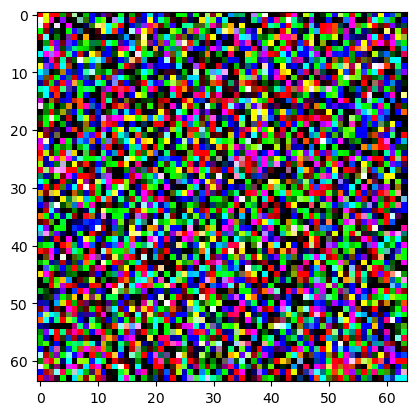

In [98]:
plt.imshow(img[0].permute(2 , 1 , 0))

In [99]:
conv_layer= nn.Conv2d(in_channels= 3 , out_channels = 64,kernel_size=3,stride=1,padding=0 )
conv_output = conv_layer(test_img)
conv_output.shape

torch.Size([64, 62, 62])

In [93]:
pool = nn.MaxPool2d(kernel_size=2)
max_pool = pool(test_img)
max_pool.shape

torch.Size([3, 32, 32])

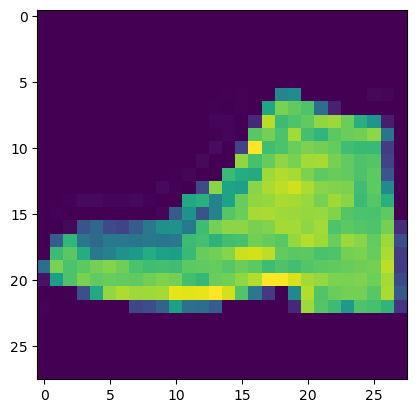

In [103]:
plt.imshow(image[0].permute(1,2,0))

In [108]:
image.shape

torch.Size([16, 1, 28, 28])

In [107]:
model(image)

torch.Size([16, 10, 14, 14])
torch.Size([16, 10, 7, 7])
torch.Size([16, 10])


tensor([[ 0.0291, -0.0632,  0.0564, -0.0308, -0.0128,  0.0135, -0.0028, -0.0098,
          0.0217,  0.0134],
        [ 0.0312, -0.0630,  0.0577, -0.0270, -0.0203,  0.0153, -0.0019, -0.0038,
          0.0216,  0.0077],
        [ 0.0271, -0.0667,  0.0528, -0.0346, -0.0132,  0.0142, -0.0024, -0.0116,
          0.0234,  0.0086],
        [ 0.0324, -0.0598,  0.0547, -0.0235, -0.0171,  0.0174, -0.0077, -0.0060,
          0.0227,  0.0108],
        [ 0.0328, -0.0624,  0.0506, -0.0297, -0.0122,  0.0200, -0.0031, -0.0156,
          0.0286,  0.0112],
        [ 0.0313, -0.0692,  0.0584, -0.0378, -0.0126,  0.0146, -0.0037, -0.0098,
          0.0174,  0.0104],
        [ 0.0281, -0.0669,  0.0523, -0.0331, -0.0112,  0.0181,  0.0012, -0.0154,
          0.0245,  0.0099],
        [ 0.0348, -0.0682,  0.0558, -0.0349, -0.0139,  0.0162,  0.0034, -0.0087,
          0.0186,  0.0130],
        [ 0.0363, -0.0658,  0.0497, -0.0326, -0.0072,  0.0136, -0.0061, -0.0146,
          0.0224,  0.0063],
        [ 0.0348, -

In [117]:
torch.manual_seed(42)
start_time = timer()
#--------------------
epochs = 20
for epoch in tqdm(range(epochs)):
    print(f"Epoch : {epoch}\n-----")    
    train_loss = 0
    for batch , (image , label) in enumerate(train_dataloader):
        model.train()
        y_pred = model(image)
        loss = loss_fn(y_pred , label)
        train_loss = train_loss + loss #loss on one batch of data
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch %400 == 0:
            print(f"looked at {batch*len(image)}/{len(train_dataloader.dataset)} samples")
    train_loss = train_loss / len(train_dataloader) #loss by the whole train data

    #testing
    test_loss , test_acc = 0 , 0
    model.eval()
    with torch.inference_mode():
        for image_test , label_test in test_dataloader:
            test_pred = model(image_test)
            test_loss = test_loss + loss_fn(test_pred , label_test)
            test_acc  = test_acc  + acc(test_pred.argmax(dim = 1) , label_test)
        test_loss = test_loss / len(test_dataloader) #test loss avg per batch
        test_acc  = test_acc  / len(test_dataloader)
    print(f"epoch : {epoch} | train_loss : {train_loss:.2f}  | test loss : {test_loss:.2f} , test acc : {test_acc:.2f}")
#--------------------
end_time = timer()
total_train_time_model_0 = print_train_time(start_time , end_time)
total_train_time_model_0

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 0
-----
looked at 0/10000 samples


  5%|▌         | 1/20 [00:03<01:14,  3.92s/it]

epoch : 0 | train_loss : 0.34  | test loss : 0.30 , test acc : 0.89
Epoch : 1
-----
looked at 0/10000 samples


 10%|█         | 2/20 [00:07<01:10,  3.94s/it]

epoch : 1 | train_loss : 0.33  | test loss : 0.32 , test acc : 0.89
Epoch : 2
-----
looked at 0/10000 samples


 15%|█▌        | 3/20 [00:11<01:06,  3.92s/it]

epoch : 2 | train_loss : 0.32  | test loss : 0.28 , test acc : 0.90
Epoch : 3
-----
looked at 0/10000 samples


 20%|██        | 4/20 [00:15<01:02,  3.88s/it]

epoch : 3 | train_loss : 0.32  | test loss : 0.29 , test acc : 0.89
Epoch : 4
-----
looked at 0/10000 samples


 25%|██▌       | 5/20 [00:19<00:58,  3.92s/it]

epoch : 4 | train_loss : 0.30  | test loss : 0.26 , test acc : 0.91
Epoch : 5
-----
looked at 0/10000 samples


 30%|███       | 6/20 [00:23<00:55,  3.93s/it]

epoch : 5 | train_loss : 0.29  | test loss : 0.31 , test acc : 0.88
Epoch : 6
-----
looked at 0/10000 samples


 35%|███▌      | 7/20 [00:27<00:51,  3.94s/it]

epoch : 6 | train_loss : 0.29  | test loss : 0.26 , test acc : 0.91
Epoch : 7
-----
looked at 0/10000 samples


 40%|████      | 8/20 [00:31<00:47,  3.93s/it]

epoch : 7 | train_loss : 0.28  | test loss : 0.24 , test acc : 0.91
Epoch : 8
-----
looked at 0/10000 samples


 45%|████▌     | 9/20 [00:35<00:43,  3.96s/it]

epoch : 8 | train_loss : 0.27  | test loss : 0.33 , test acc : 0.88
Epoch : 9
-----
looked at 0/10000 samples


 50%|█████     | 10/20 [00:39<00:41,  4.15s/it]

epoch : 9 | train_loss : 0.26  | test loss : 0.24 , test acc : 0.91
Epoch : 10
-----
looked at 0/10000 samples


 55%|█████▌    | 11/20 [00:44<00:37,  4.22s/it]

epoch : 10 | train_loss : 0.26  | test loss : 0.28 , test acc : 0.89
Epoch : 11
-----
looked at 0/10000 samples


 60%|██████    | 12/20 [00:48<00:34,  4.25s/it]

epoch : 11 | train_loss : 0.25  | test loss : 0.23 , test acc : 0.92
Epoch : 12
-----
looked at 0/10000 samples


 65%|██████▌   | 13/20 [00:53<00:30,  4.31s/it]

epoch : 12 | train_loss : 0.25  | test loss : 0.24 , test acc : 0.91
Epoch : 13
-----
looked at 0/10000 samples


 70%|███████   | 14/20 [00:57<00:26,  4.34s/it]

epoch : 13 | train_loss : 0.24  | test loss : 0.28 , test acc : 0.89
Epoch : 14
-----
looked at 0/10000 samples


 75%|███████▌  | 15/20 [01:01<00:21,  4.30s/it]

epoch : 14 | train_loss : 0.24  | test loss : 0.25 , test acc : 0.91
Epoch : 15
-----
looked at 0/10000 samples


 80%|████████  | 16/20 [01:06<00:17,  4.29s/it]

epoch : 15 | train_loss : 0.24  | test loss : 0.22 , test acc : 0.92
Epoch : 16
-----
looked at 0/10000 samples


 85%|████████▌ | 17/20 [01:10<00:12,  4.30s/it]

epoch : 16 | train_loss : 0.23  | test loss : 0.26 , test acc : 0.90
Epoch : 17
-----
looked at 0/10000 samples


 90%|█████████ | 18/20 [01:14<00:08,  4.28s/it]

epoch : 17 | train_loss : 0.23  | test loss : 0.24 , test acc : 0.92
Epoch : 18
-----
looked at 0/10000 samples


 95%|█████████▌| 19/20 [01:18<00:04,  4.30s/it]

epoch : 18 | train_loss : 0.22  | test loss : 0.20 , test acc : 0.93
Epoch : 19
-----
looked at 0/10000 samples


100%|██████████| 20/20 [01:23<00:00,  4.16s/it]

epoch : 19 | train_loss : 0.22  | test loss : 0.20 , test acc : 0.93


83.20742699998664

In [118]:
eval_model(model , test_dataloader,loss_fn , acc)

100%|██████████| 313/313 [00:00<00:00, 353.47it/s]


{'model_name': 'CNN',
 'model_loss': 1.0371190309524536,
 'model acc': tensor(0.8308)}

In [132]:
def make_predictions(model , data):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample , dim = 0)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze() , dim= 0)
            pred_probs.append(pred_prob)
    return torch.stack(pred_probs)

In [161]:
import random
test_samples= []
test_labels = []
for sample , label in random.sample(list(test_data) , k = 20):
    test_samples.append(sample)
    test_labels.append(label)

In [162]:
label = list(make_predictions(model , test_samples).argmax(dim = 1).numpy())

In [163]:
label

[0, 0, 7, 0, 8, 5, 9, 3, 4, 4, 1, 4, 5, 9, 3, 8, 5, 5, 0, 5]

In [164]:
test_labels

[0, 0, 7, 0, 8, 5, 9, 3, 6, 4, 1, 4, 5, 9, 3, 8, 5, 5, 6, 5]

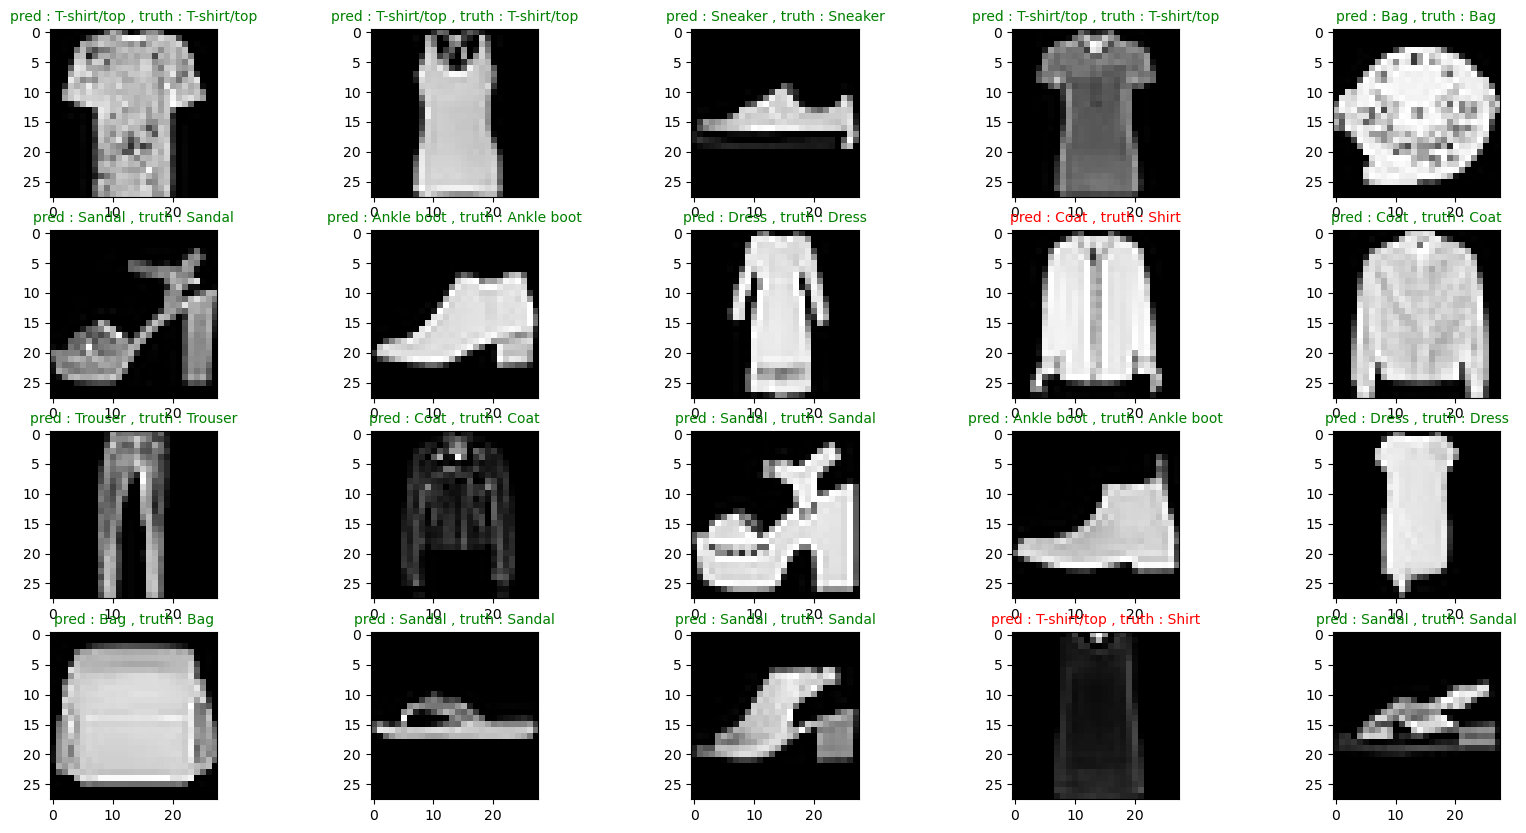

In [165]:
plt.figure(figsize=(20 , 10))
n_rows=4
n_cols= 5
for i , sample in enumerate(test_samples):
    plt.subplot(n_rows , n_cols , i + 1)
    plt.imshow(sample.squeeze() , cmap = "gray")
    pred_label = class_names[label[i]]
    truth_label = class_names[test_labels[i]]
    title_Text = f"pred : {pred_label} , truth : {truth_label}"
    if pred_label == truth_label:
        plt.title(title_Text , fontsize = 10 , color = "g")
    else:
        plt.title(title_Text , fontsize = 10 , color = "r")

In [171]:
import mlxtend #for conf matrix
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

In [169]:
# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 313/313 [00:01<00:00, 213.93it/s]


In [176]:
confmat = ConfusionMatrix(num_classes=len(class_names), task = "multiclass")
confmat_tensor = confmat(preds = y_pred_tensor , target = test_data.targets)

In [175]:
test_data.targets

tensor([9, 2, 1,  ..., 8, 1, 5])

In [177]:
confmat_tensor

tensor([[942,   0,   3,  16,   2,   0,  37,   0,   0,   0],
        [  1, 983,   0,  14,   0,   0,   2,   0,   0,   0],
        [ 12,   0, 745,  10, 134,   0,  99,   0,   0,   0],
        [ 13,   0,   1, 972,   2,   0,  12,   0,   0,   0],
        [  2,   0,   6,  24, 918,   0,  50,   0,   0,   0],
        [  1,   0,   0,   0,   0, 993,   0,   3,   2,   1],
        [122,   1,  15,  22,  40,   0, 799,   0,   1,   0],
        [  0,   0,   0,   0,   0,  10,   0, 951,   0,  39],
        [  0,   0,   0,   5,   3,   0,   2,   0, 990,   0],
        [  0,   0,   0,   0,   0,   0,   0,   2,   0, 998]])

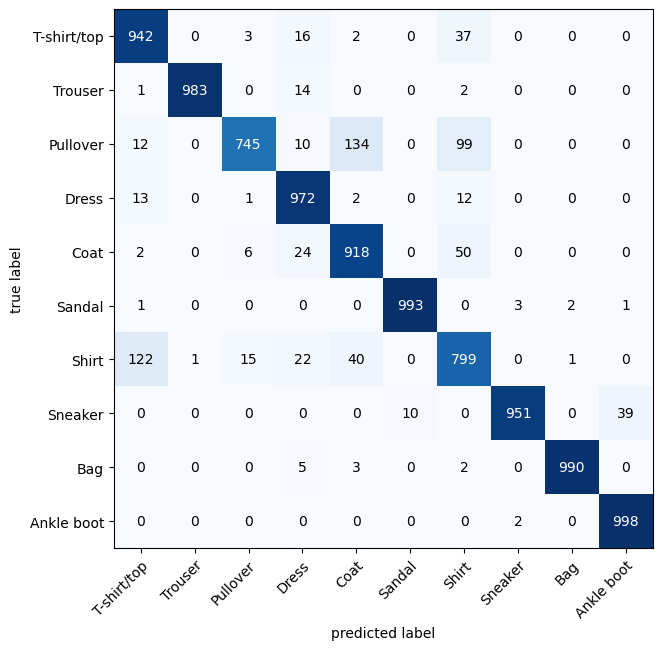

In [180]:
fig , ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize = (10,7)
)

In [183]:
os.getcwd()

'D:\\data science\\fashion mnist dataset'

In [185]:
model_path = 'D:\\data science\\fashion mnist dataset\\fashion_model.pth'

In [186]:
torch.save(obj= model.state_dict, f = model_path)